In [199]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

# import fields as f
# import fields_plot as fp
from pynvcenter import nv_optical_response as nv


import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt

%matplotlib inline


%load_ext autoreload
%autoreload 2




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## define functions

### version 1 plotting contrast and frequencies

In [ ]:

def plot_esr_map(particle_radius = 30, nv_radius = 70, nv_x=0, nv_y = 0, theta_mag = 0, phi_mag = 45):
    nv_po = np.array([nv_x, nv_y]) # center of ring where we measure the nvs
    angle = np.linspace(0, 360, 51)

    Br = 0.1 # surface field of magnet in Tesla

    mu0 = 4 * np.pi * 1e-7  # T m /A

    dipole_height = 80 # height of the dipole in um

    dipole_strength = 4*np.pi/3 *(particle_radius)**3 / mu0


    # positions of NV centers
    nv_pos = np.array([nv_radius*np.cos(angle/180*np.pi)+nv_po[0],
                       nv_radius*np.sin(angle/180*np.pi)+nv_po[1]]).T



    # get physical units
    r = np.hstack([nv_pos, np.zeros([len(nv_pos), 1])]) # nvs are assumed to be in the z=0 plane
    DipolePosition = np.array([0, 0, -dipole_height]) # position of dipole is at -dipole_position in z-direction and 0,0 in xy
    tm = np.pi/180 * theta_mag
    pm = np.pi/180 * phi_mag
    m = dipole_strength*np.array([np.cos(pm)*np.sin(tm), np.sin(pm)*np.sin(tm), np.cos(tm)])

    fig, ax = plt.subplots(1, 2, figsize = (12, 4))

    # calc field
    bfields = b_field_single_dipole(r, DipolePosition, m)

    esr_contrast = nv.esr_contrast_ensemble(bfields)

    for c in np.array([contrast.flatten() for contrast in esr_contrast]).T:
        ax[0].plot(c,angle)

    #     for c in esr_contrast.T:
    # #         ax[0].plot(np.sum(bfields**2, axis=1))
    #         ax[0].plot(c)

    esr_freq = nv.esr_frequencies_ensemble(bfields)


    for f in np.array([freq.flatten() for freq in esr_freq]).T:
        ax[1].plot(f, angle)

    ax[0].set_xlabel('contrast')
    ax[0].set_ylabel('angle (deg)')
    ax[0].set_xlabel('freq (Hz)')
    ax[1].set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))

### version 2 plotting only frequencies

In [122]:

def plot_esr_map(particle_radius = 30, nv_radius = 70, nv_x=0, nv_y = 0, theta_mag = 0, phi_mag = 45):
    nv_po = np.array([nv_x, nv_y]) # center of ring where we measure the nvs
    angle = np.linspace(0, 360, 101)

    Br = 0.1 # surface field of magnet in Tesla

    mu0 = 4 * np.pi * 1e-7  # T m /A

    dipole_height = 80 # height of the dipole in um

    dipole_strength = 4*np.pi/3 *(particle_radius)**3 / mu0


    # positions of NV centers
    nv_pos = np.array([nv_radius*np.cos(angle/180*np.pi)+nv_po[0],
                       nv_radius*np.sin(angle/180*np.pi)+nv_po[1]]).T



    # get physical units
    r = np.hstack([nv_pos, np.zeros([len(nv_pos), 1])]) # nvs are assumed to be in the z=0 plane
    DipolePosition = np.array([0, 0, -dipole_height]) # position of dipole is at -dipole_position in z-direction and 0,0 in xy
    tm = np.pi/180 * theta_mag
    pm = np.pi/180 * phi_mag
    m = dipole_strength*np.array([np.cos(pm)*np.sin(tm), np.sin(pm)*np.sin(tm), np.cos(tm)])

    fig, ax = plt.subplots(1, 1, figsize = (6, 4))

    # calc field
    bfields = b_field_single_dipole(r, DipolePosition, m)

    esr_freq = nv.esr_frequencies_ensemble(bfields)
    
    # sort freq such that lines are connected
#     esr_freq = nv.esr_connect(esr_freq)
    
    color = ['r', 'g', 'b', 'k']
    line = ['-', '--']
    for i, f in enumerate(np.array([freq.flatten() for freq in esr_freq]).T):
        ax.plot(f, angle, color[i // 2] + line[i % 2])

    ax.set_ylabel('angle (deg)')
    ax.set_xlabel('freq (Hz)')
    ax.set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))

In [112]:
from pynvcenter.fields import b_field, b_field_single_dipole

In [113]:


particle_radius = 30 # particle radius in um

nv_radius = 70  # radius at which we measure the nvs

nv_x, nv_y = 5,0

theta_mag = 10 # theta angle of dipole orientation in degree
phi_mag = 45 # phi angle of dipole orientation in degree


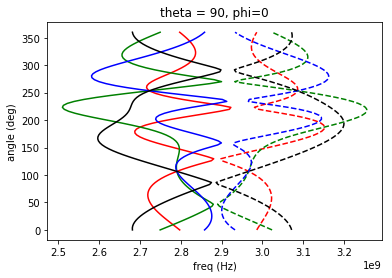

In [133]:
for x in [20]:

    plot_esr_map(particle_radius = 30, nv_radius = 70, nv_x=x, nv_y = x, theta_mag = 90, phi_mag = 0)

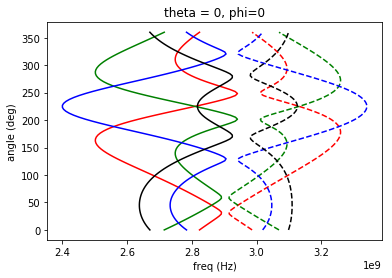

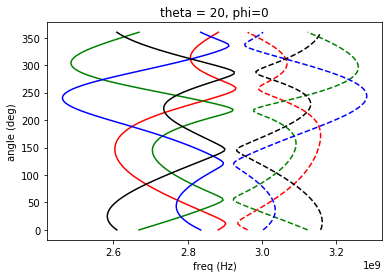

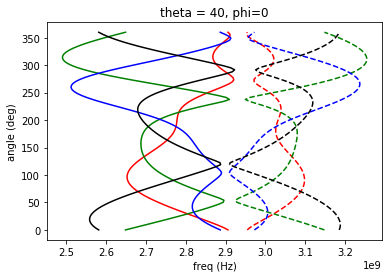

In [123]:
for t in [0, 20, 40]:

    plot_esr_map(particle_radius = 30, nv_radius = 70, nv_x=10, nv_y = 10, theta_mag = t, phi_mag = 0)

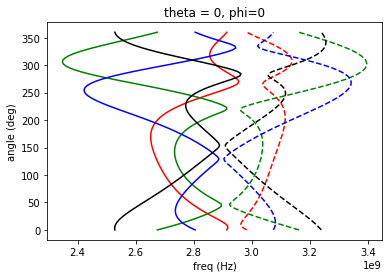

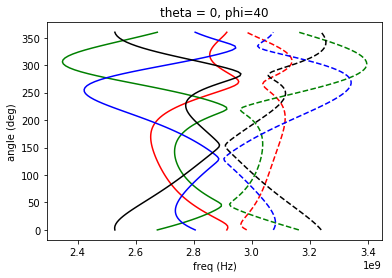

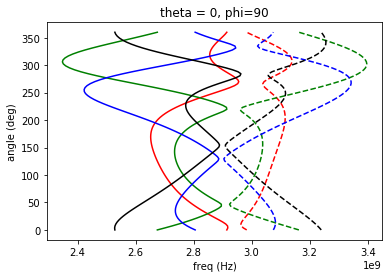

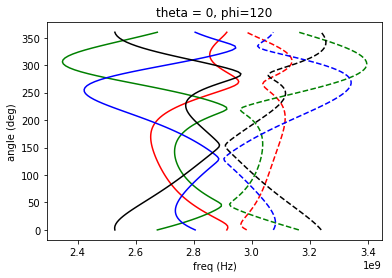

In [155]:
displacement = 20
angle = 115

angle *=np.pi/180 # convert to radians

x = np.cos(angle) * displacement
y = np.sin(angle) * displacement

for p in [0, 40, 90, 120]:

    plot_esr_map(particle_radius = 30, nv_radius = 70, nv_x=x, nv_y =y , theta_mag = 0, phi_mag = p)

### version 3 - a 2D map

In [389]:

def plot_esr_2D_map(particle_radius = 30, nv_radius = 70, nv_x=0, nv_y = 0, theta_mag = 0, phi_mag = 45,
                    dipole_height = 80, shot_noise=0, linewidth=1e7, n_angle=51, n_freq=501, f_min=2.65e9, f_max=3.15e9,
                   return_data = False, show_plot=True):
    """
         dipole_height = height of the dipole in um
    """
    nv_po = np.array([nv_x, nv_y]) # center of ring where we measure the nvs
    angle = np.linspace(0, 360, n_angle)
    
    frequencies = np.linspace(f_min, f_max, n_freq)

    Br = 0.1 # surface field of magnet in Tesla

    mu0 = 4 * np.pi * 1e-7  # T m /A

    dipole_strength = 4*np.pi/3 *(particle_radius)**3 / mu0


    # positions of NV centers
    nv_pos = np.array([nv_radius*np.cos(angle/180*np.pi)+nv_po[0],
                       nv_radius*np.sin(angle/180*np.pi)+nv_po[1]]).T



    # get physical units
    r = np.hstack([nv_pos, np.zeros([len(nv_pos), 1])]) # nvs are assumed to be in the z=0 plane
    DipolePosition = np.array([0, 0, -dipole_height]) # position of dipole is at -dipole_position in z-direction and 0,0 in xy
    tm = np.pi/180 * theta_mag
    pm = np.pi/180 * phi_mag
    m = dipole_strength*np.array([np.cos(pm)*np.sin(tm), np.sin(pm)*np.sin(tm), np.cos(tm)])


    # calc field
    bfields = b_field_single_dipole(r, DipolePosition, m)

    esr_contrast = nv.esr_contrast_ensemble(bfields)

    esr_freq = nv.esr_frequencies_ensemble(bfields)
    
    signal = []
    for fo, contrast in zip(esr_freq, esr_contrast):
        signal.append(nv.esr_odmr_signal_ensemble(
            frequencies,
            fo.flatten(), contrast.flatten(), 
            avrg_count_rate,
            linewidth=linewidth,
            shot_noise=shot_noise)
                     )
    signal = np.array(signal)
    
    if show_plot:
        fig, ax = plt.subplots(1, 1, figsize = (6, 4))
        ax.pcolor(frequencies,angle, signal)

        ax.set_ylabel('angle (deg)')
        ax.set_xlabel('freq (Hz)')
        ax.set_title('theta = {:0.0f}, phi={:0.0f}'.format(theta_mag, phi_mag))
        plt.tight_layout()
    
    if return_data:
        return signal

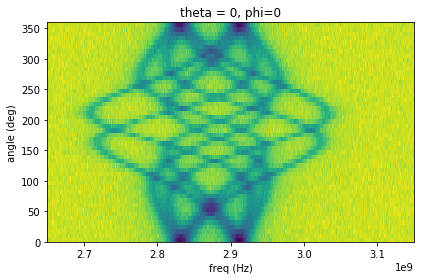

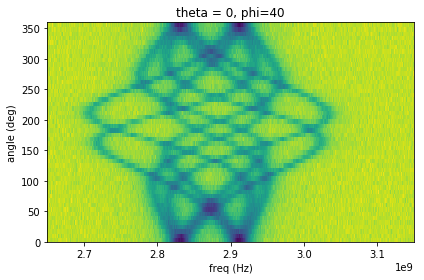

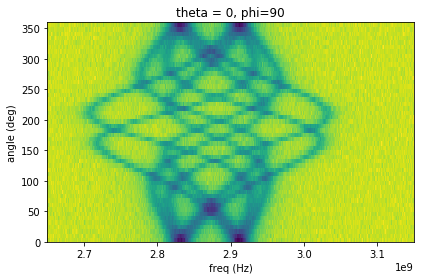

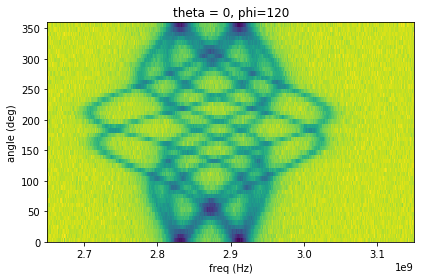

In [272]:
displacement = 20
angle = 10
dipole_height = 80
angle *=np.pi/180 # convert to radians

x = np.cos(angle) * displacement
y = np.sin(angle) * displacement

for p in [0, 40, 90, 120]:

    plot_esr_2D_map(particle_radius = 22, nv_radius = 80, nv_x=x, nv_y =y,
                    dipole_height=dipole_height, theta_mag = 0, phi_mag = p,shot_noise=5)

## create images

In [378]:
def make_param_df(parameters):
    dfs = [pd.DataFrame.from_dict({k: v, 'key':0}) for k, v in parameters.items()]

    df = pd.DataFrame.from_dict({'key':[0]})

    for df_tmp in dfs:
        df = pd.merge(df,df_tmp, on='key')
    del df['key']

    print('%d different values' % np.product([len(df_tmp) for df_tmp in dfs]))
    df = df.astype('float') # reduce memory
    df['nv_x'] = np.cos(df['angle']) * df['displacement']
    df['nv_y'] = np.sin(df['angle']) * df['displacement']
    return df

In [384]:


parameters = {
    'displacement':np.arange(0,10,1),
    'particle_radius':np.arange(18,20, 1),
    'nv_radius':[80],
    'theta_mag':[0],
    'phi_mag':[10],
    'dipole_height':[80],
    'shot_noise':[5],
    'angle':[0]
}



### save parameters

In [385]:
df = make_param_df(parameters)
df.to_csv('parameters.csv')


20 different values


### load parameters

In [386]:

df = pd.read_csv('parameters.csv', index_col=0)
del df['displacement']
del df['angle']

In [387]:
df.iloc[10].to_dict()

{'particle_radius': 18.0,
 'nv_radius': 80.0,
 'theta_mag': 0.0,
 'phi_mag': 10.0,
 'dipole_height': 80.0,
 'shot_noise': 5.0,
 'nv_x': 5.0,
 'nv_y': 0.0}

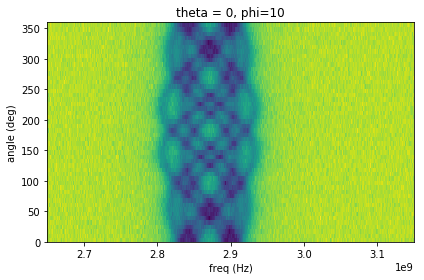

In [390]:
plot_esr_2D_map(**df.iloc[10].to_dict())

In [392]:
signal.shape

(51, 501)

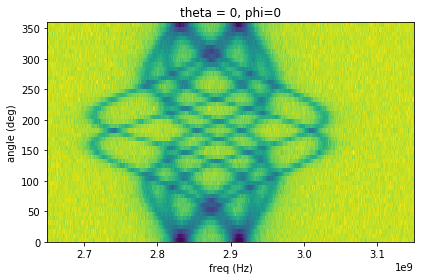

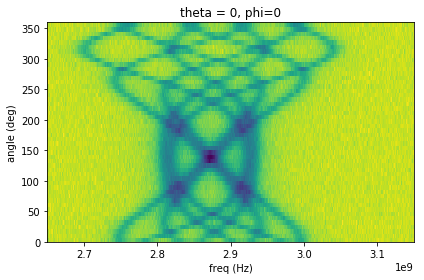

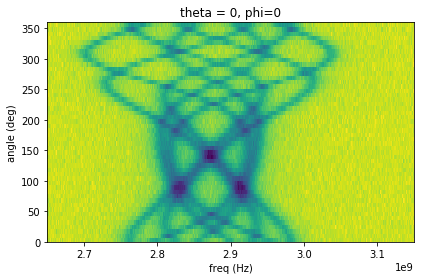

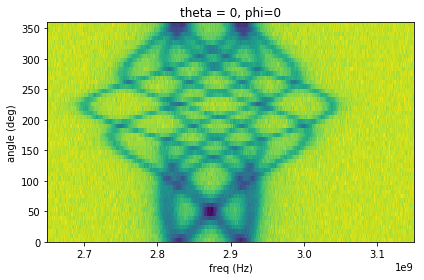

In [273]:
displacement = 20
p = 0
dipole_height = 80
angle *=np.pi/180 # convert to radians



for angle in [0, 40, 90, 120]:
    x = np.cos(angle) * displacement
    y = np.sin(angle) * displacement
    plot_esr_2D_map(particle_radius = 22, nv_radius = 80, nv_x=x, nv_y =y,
                    dipole_height=dipole_height, theta_mag = 0, phi_mag = p,shot_noise=5)

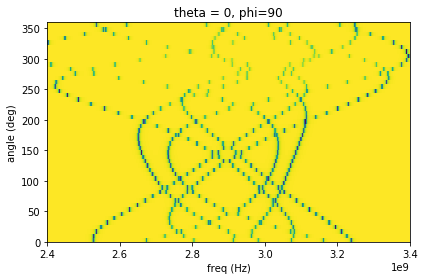

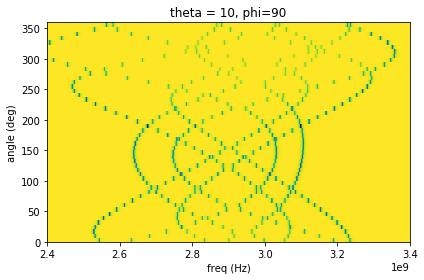

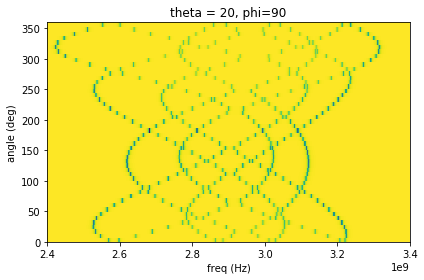

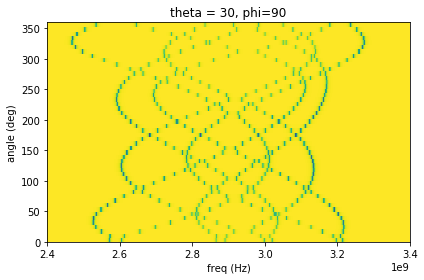

In [228]:
displacement = 20
angle = 115

angle *=np.pi/180 # convert to radians

x = np.cos(angle) * displacement
y = np.sin(angle) * displacement

for t in [0, 10, 20, 30]:

    plot_esr_2D_map(particle_radius = 30, nv_radius = 70, nv_x=x, nv_y =y , theta_mag = t, phi_mag = 90)

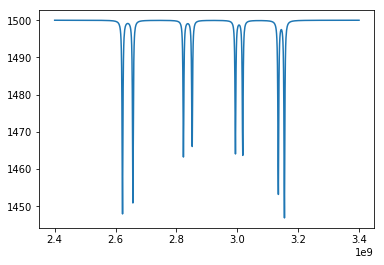

In [201]:

plt.plot(frequencies, signal)

In [182]:
contrast, co, c1

(14.524172089515192, 1500.0, 1500)

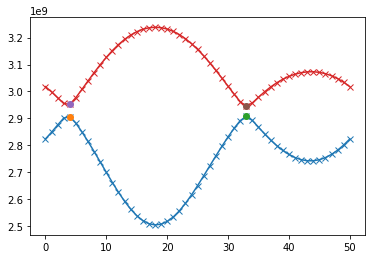

In [68]:



x = np.diff(esr_freq.reshape(esr_freq.shape[0],8)[:,0:2])[:,0]
# plt.plot(x, 'x-')

peaks, _ = find_peaks(1/x, distance=5)



    
for signal in esr_freq.reshape(esr_freq.shape[0],8)[:,0:2].T:
    plt.plot(signal, 'x-') 
    for p in peaks:
        plt.plot(p, signal[p], 'o')

In [69]:
a, b = esr_freq.reshape(esr_freq.shape[0],8)[:,0:2].T

In [72]:
p1, p2  = peaks

In [74]:
a, b = np.hstack([a[0:p1], b[p1:p2], a[p2:]]), np.hstack([b[0:p1], a[p1:p2], b[p2:]])

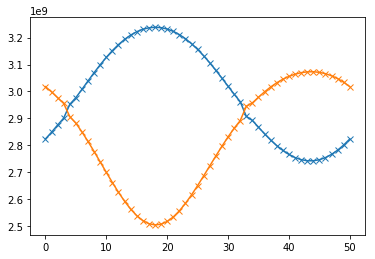

In [76]:
plt.plot(a, '-x')
plt.plot(b, '-x')

array([110,  90, 117,  90,  99,  82,  90, 107,  83,  95])

In [234]:
from random import random

In [235]:
?random

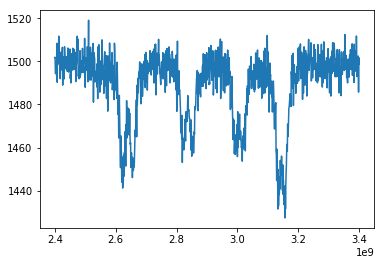

In [268]:
plt.plot(frequencies, nv.esr_odmr_signal_ensemble(frequencies, fo.flatten(), contrast.flatten(), avrg_count_rate, linewidth=1e7, shot_noise=5))

In [269]:
# i=1
# plt.plot(frequencies, nv.esr_odmr_signal(frequencies, fo[i], contrast[i], avrg_count_rate, linewidth=1e7,
#                                                   shot_noise=53))

TypeError: esr_odmr_signal() got multiple values for argument 'linewidth'

## Train a neural network

### load parameter

In [393]:
df = pd.read_csv('parameters.csv', index_col=0)
del df['displacement']
del df['angle']

### construct feature and target vectors

In [ ]:

# get the signal X from the parameter


In [401]:
X = []

for i, row in df.iterrows():
    X.append(plot_esr_2D_map(**row.to_dict(), show_plot=False, return_data=True))
X = np.array(signal)

In [403]:
X.shape

(20, 51, 501)

In [409]:
df.head()

,particle_radius,nv_radius,theta_mag,phi_mag,dipole_height,shot_noise,nv_x,nv_y
0,18.0,80.0,0.0,10.0,80.0,5.0,0.0,0.0
1,19.0,80.0,0.0,10.0,80.0,5.0,0.0,0.0
2,18.0,80.0,0.0,10.0,80.0,5.0,1.0,0.0
3,19.0,80.0,0.0,10.0,80.0,5.0,1.0,0.0
4,18.0,80.0,0.0,10.0,80.0,5.0,2.0,0.0


In [414]:
Y = df[['nv_x', 'particle_radius']]

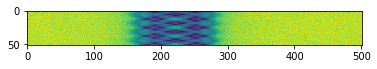

In [404]:
plt.imshow(X[0])

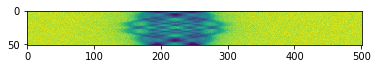

In [406]:
plt.imshow(X[18])

### build the neural network

In [ ]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [ ]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
?KerasRegressor

In [ ]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)

In [ ]:
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, Y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))